In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import torchvision.transforms as T

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

In [18]:
# Set paths for dataset
data_dir = '/content/drive/MyDrive/ColabNotebooks/'  # Change this path to where you stored the dataset
train_zip = os.path.join(data_dir, 'TrainIJCNN2013.zip')
test_zip = os.path.join(data_dir, 'TestIJCNN2013.zip')
annotations_file = '/content/drive/MyDrive/ColabNotebooks/gt.txt'

In [3]:
# -*- coding: utf-8 -*-
"""GTSDB_Faster_RCNN.ipynb"""

# Import necessary libraries
import os
import zipfile
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Extract the dataset
train_dir = '/content/train/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")
train_dir = '/content/train/TrainIJCNN2013/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download/TestIJCNN2013Download'


Dataset extracted successfully.


In [19]:
import shutil

train_dir = 'TrainIJCNN2013'
test_dir = 'TestIJCNN2013Download'
shutil.copy(annotations_file, train_dir)
annotations_file = "/content/TrainIJCNN2013/gt.txt"

In [34]:
# Λίστα για αποθήκευση διαστάσεων
image_dimensions = []

# Διαπέραση όλων των αρχείων στον φάκελο
for filename in os.listdir(train_dir):
    if filename.endswith(".ppm"):  # Έλεγχος για αρχεία .ppm
        file_path = os.path.join(train_dir, filename)
        with Image.open(file_path) as img:
            width, height = img.size  # Απόκτηση πλάτους και ύψους
            image_dimensions.append((filename, width, height))
            print(f"Image: {filename}, Width: {width}, Height: {height}")

# Ανάλυση των αποτελεσμάτων
print(f"\nTotal images: {len(image_dimensions)}")
print(f"Example dimensions: {image_dimensions[:5]}")

Image: 00311.ppm, Width: 1360, Height: 800
Image: 00533.ppm, Width: 1360, Height: 800
Image: 00236.ppm, Width: 1360, Height: 800
Image: 00593.ppm, Width: 1360, Height: 800
Image: 00556.ppm, Width: 1360, Height: 800
Image: 00092.ppm, Width: 1360, Height: 800
Image: 00376.ppm, Width: 1360, Height: 800
Image: 00282.ppm, Width: 1360, Height: 800
Image: 00396.ppm, Width: 1360, Height: 800
Image: 00249.ppm, Width: 1360, Height: 800
Image: 00560.ppm, Width: 1360, Height: 800
Image: 00251.ppm, Width: 1360, Height: 800
Image: 00298.ppm, Width: 1360, Height: 800
Image: 00013.ppm, Width: 1360, Height: 800
Image: 00067.ppm, Width: 1360, Height: 800
Image: 00500.ppm, Width: 1360, Height: 800
Image: 00460.ppm, Width: 1360, Height: 800
Image: 00169.ppm, Width: 1360, Height: 800
Image: 00240.ppm, Width: 1360, Height: 800
Image: 00508.ppm, Width: 1360, Height: 800
Image: 00284.ppm, Width: 1360, Height: 800
Image: 00170.ppm, Width: 1360, Height: 800
Image: 00257.ppm, Width: 1360, Height: 800
Image: 0022

In [20]:
import torch
import os

def parse_annotations(annotations_file, image_dir):
    annotations = []

    # Φόρτωση των annotations
    with open(annotations_file, "r") as f:
        for line_no, line in enumerate(f.readlines()):
            if line_no == 0:  # Παράλειψη της γραμμής επικεφαλίδας
                continue
            fields = line.strip().split(",")
            if len(fields) != 6:  # Αναμενόμενες στήλες: filename, x1, y1, x2, y2, class
                print(f"Skipping malformed line {line_no + 1}: {line.strip()}")
                continue
            filename, x1, y1, x2, y2, class_id = fields
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            class_id = int(class_id)
            # Έλεγχος για bounding boxes εκτός ορίων εικόνας
            if x1 < 0 or y1 < 0 or x2 > 2048 or y2 > 2048:
                print(f"Skipping bounding box out of bounds: {filename}, [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για μη έγκυρα bounding boxes
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για πολύ μικρά bounding boxes
            if abs(x2 - x1) < 10 or abs(y2 - y1) < 10:
                print(f"Skipping small bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Προσθήκη στα annotations
            annotations.append({
                "filename": filename,
                "bbox": [x1, y1, x2, y2],
                "label": class_id
            })

    return annotations
    return annotations


# Example usage
annotations = parse_annotations(annotations_file, train_dir)

# Check the first few annotations to verify the format
print(annotations[:5])
annotations = parse_annotations(annotations_file, train_dir)
print(f"Parsed Annotations: {annotations[:5]}")  # Εμφάνιση των πρώτων 5 γραμμών
print(f"Total annotations: {len(annotations)}")

[{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox': [892.0, 476.0, 1006.0, 592.0], 'label': 39}]
Parsed Annotations: [{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox

In [21]:
# Define the dataset class for GTSDB
class GTSDBDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.annotations = parse_annotations(annotations_file, image_dir)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation["filename"])
        img = Image.open(img_path).convert("RGB")

        # Convert bounding boxes and labels to tensors
        bbox = torch.tensor([annotation["bbox"]], dtype=torch.float32)  # (num_boxes, 4)
        label = torch.tensor([annotation["label"]], dtype=torch.int64)  # (num_boxes,)

        target = {"boxes": bbox, "labels": label}

        # Apply transformations if any
        if self.transforms:
            img = self.transforms(img)

        return img, target

In [35]:
# Define transforms for the dataset
transforms = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

# Load the dataset
train_dataset = GTSDBDataset(train_dir, annotations_file, transforms=transforms)
test_dataset = GTSDBDataset(test_dir, annotations_file, transforms=transforms)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [36]:
# Define Faster R-CNN model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

def get_faster_rcnn_model(num_classes):
    """
    Load Faster R-CNN with a ResNet50 backbone and modify it for GTSDB.
    """
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with one for our dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
num_classes = 43  # 42 traffic sign classes + 1 background
model = get_faster_rcnn_model(num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def evaluate_precision_recall(model, dataloader, device, confidence_threshold=0.1):
    model.eval()  # Set model to evaluation mode
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                # Filter predictions based on confidence threshold
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_labels = pred_labels[mask]

                # Append the ground truth and predicted labels
                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)

    # Convert to numpy arrays for evaluation
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Compute precision and recall
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)

    return precision, recall


In [38]:
import os
import torch
from tqdm import tqdm
checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/checkpoint.pth'

# Training loop with model saving after each epoch and loss calculation
def train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints'):
    model.train()
    best_loss = float('inf')
    best_epoch = 0

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # Γραμμή προόδου
        total_loss = 0

        for images, targets in pbar:
            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())  # Total loss
            total_loss += loss.item()

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ενημέρωση της γραμμής προόδου
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

        # Save the model after every epoch if loss is improving
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch + 1  # Store best epoch
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{best_epoch}_loss_{avg_loss:.4f}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved at epoch {best_epoch} with avg_loss {avg_loss:.4f}")

    # Final model saving after all epochs
    final_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Best model saved after epoch {best_epoch} with loss {best_loss:.4f}")

    # Αποθήκευση checkpoint στο Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss
    }, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")

train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints')

Epoch 1/10: 100%|██████████| 107/107 [02:00<00:00,  1.13s/it, loss=0.213]


Epoch 1, Loss: 0.5570
Model saved at epoch 1 with loss 0.5570


Epoch 2/10: 100%|██████████| 107/107 [02:01<00:00,  1.13s/it, loss=0.32]


Epoch 2, Loss: 0.2215
Model saved at epoch 2 with loss 0.2215


Epoch 3/10: 100%|██████████| 107/107 [02:02<00:00,  1.14s/it, loss=0.216]


Epoch 3, Loss: 0.2209
Model saved at epoch 3 with loss 0.2209


Epoch 4/10: 100%|██████████| 107/107 [02:02<00:00,  1.14s/it, loss=0.174]


Epoch 4, Loss: 0.1928
Model saved at epoch 4 with loss 0.1928


Epoch 5/10: 100%|██████████| 107/107 [02:02<00:00,  1.14s/it, loss=0.152]


Epoch 5, Loss: 0.1714
Model saved at epoch 5 with loss 0.1714


Epoch 6/10: 100%|██████████| 107/107 [02:01<00:00,  1.14s/it, loss=0.228]


Epoch 6, Loss: 0.1619
Model saved at epoch 6 with loss 0.1619


Epoch 7/10: 100%|██████████| 107/107 [02:02<00:00,  1.14s/it, loss=0.15]


Epoch 7, Loss: 0.1543
Model saved at epoch 7 with loss 0.1543


Epoch 8/10: 100%|██████████| 107/107 [02:02<00:00,  1.14s/it, loss=0.1]


Epoch 8, Loss: 0.1395
Model saved at epoch 8 with loss 0.1395


Epoch 9/10: 100%|██████████| 107/107 [02:01<00:00,  1.14s/it, loss=0.0994]


Epoch 9, Loss: 0.1311
Model saved at epoch 9 with loss 0.1311


Epoch 10/10: 100%|██████████| 107/107 [02:01<00:00,  1.13s/it, loss=1.3e+4]


Epoch 10, Loss: 139.8001
Best model saved after epoch 9 with loss 0.1311
Checkpoint saved to /content/drive/MyDrive/ColabNotebooks/checkpoint.pth


In [42]:
import shutil
import os

# Ορισμός του φακέλου που θέλουμε να αντιγράψουμε
checkpoint_path = '/content/checkpoints'
destination_dir = '/content/drive/MyDrive/ColabNotebooks/checkpoints_drive'  # Στο Google Drive

# Αν ο φάκελος προορισμού υπάρχει, διαγράψτε τον
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)  # Διαγραφή του φακέλου

# Αντιγραφή ολόκληρου του φακέλου από το checkpoint_path στο destination_dir
shutil.copytree(checkpoint_path, destination_dir)

print(f"Folder copied from {checkpoint_path} to {destination_dir}")


Folder copied from /content/checkpoints to /content/drive/MyDrive/ColabNotebooks/checkpoints_drive


In [44]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Καθορισμός της συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Αρχικοποίηση του μοντέλου
num_classes = 43  # 42 κατηγορίες + background
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3. Φόρτωση των weights
model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/best_model.pth"))
model.load_state_dict(torch.load("/content/checkpoints/model_epoch_9_loss_0.1311.pth"))

# Μεταφορά του μοντέλου στη σωστή συσκευή
model.to(device)

print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with best loss {best_loss}")

# 4. Μεταφορά του μοντέλου στη συσκευή
model.to(device)
model.eval()  # Set to evaluation mode

# 5. Inference Loop
with torch.no_grad():
    for images, targets in test_loader:
        # Μεταφορά των εικόνων στη συσκευή
        images = [img.to(device) for img in images]

        # Εκτέλεση προβλέψεων
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            print(f"Prediction {i}:")
            print(f"Boxes: {prediction['boxes']}")
            print(f"Labels: {prediction['labels']}")
            print(f"Scores: {prediction['scores']}")


<ipython-input-44-e0594b5c3da2>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/b

Streaming output truncated to the last 5000 lines.
        [1192.4994,  484.7251, 1243.0536,  548.1897],
        [ 415.6068,  506.7305,  474.4681,  560.5756],
        [1184.5323,  487.2252, 1248.6460,  542.9352],
        [ 400.8225,  501.1196,  494.3916,  583.1657],
        [ 411.1513,  507.1520,  476.3027,  557.9103],
        [1188.7803,  487.5691, 1246.5360,  545.6045],
        [1183.8075,  485.7048, 1253.0330,  548.8698],
        [ 413.6550,  503.2002,  479.6179,  563.7220],
        [ 416.9759,  505.1291,  477.0397,  560.5345],
        [1173.6025,  469.1633, 1267.7349,  574.2977]], device='cuda:0')
Labels: tensor([18, 18, 11, 11, 25, 25, 18, 18, 30, 30, 11, 25, 26, 26, 28, 18, 28, 22,
        20, 20, 22, 18], device='cuda:0')
Scores: tensor([0.2297, 0.2191, 0.2186, 0.1886, 0.1846, 0.1643, 0.1600, 0.1510, 0.1185,
        0.1128, 0.0982, 0.0839, 0.0836, 0.0827, 0.0751, 0.0713, 0.0695, 0.0636,
        0.0598, 0.0596, 0.0541, 0.0536], device='cuda:0')
Prediction 3:
Boxes: tensor([[ 414.

In [45]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Map class IDs to class names
CLASS_ID_TO_INT = {i: i for i in range(42)}  # 42 κατηγορίες
CLASS_ID_TO_INT[0] = 0  # Το background

def visualize_predictions(image_path, model, threshold=0.1):
    """
    Visualize predictions on a single image.

    Args:
    - image_path: Path to the input image.
    - model: Trained Faster R-CNN model.
    - threshold: Confidence threshold for displaying predictions.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model([img_tensor])

    # Extract boxes, labels, and scores
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # Draw boxes on the original image
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = CLASS_ID_TO_INT[label]

            # Draw rectangle and label
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Visualizing predictions for: 00236.ppm


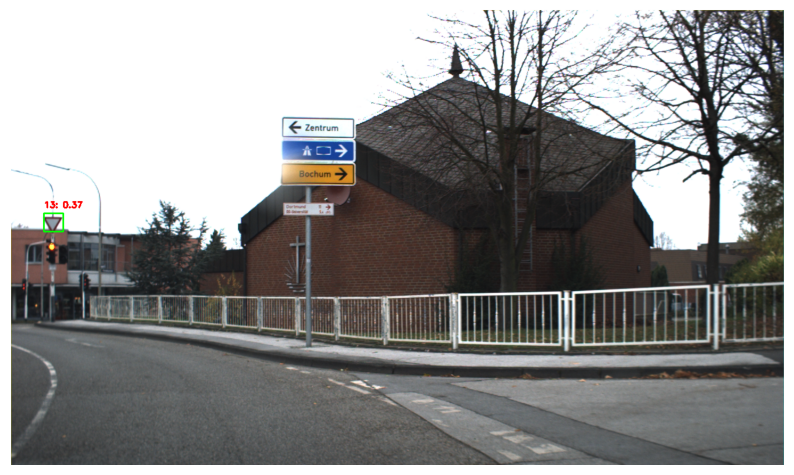

Visualizing predictions for: 00092.ppm


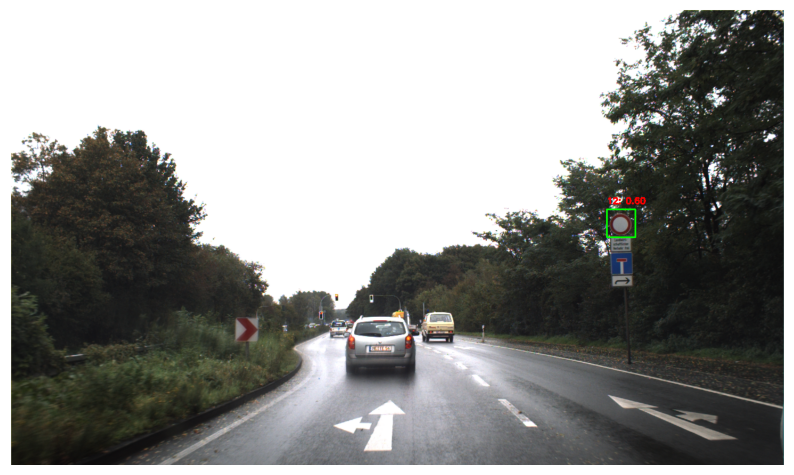

Visualizing predictions for: 00282.ppm


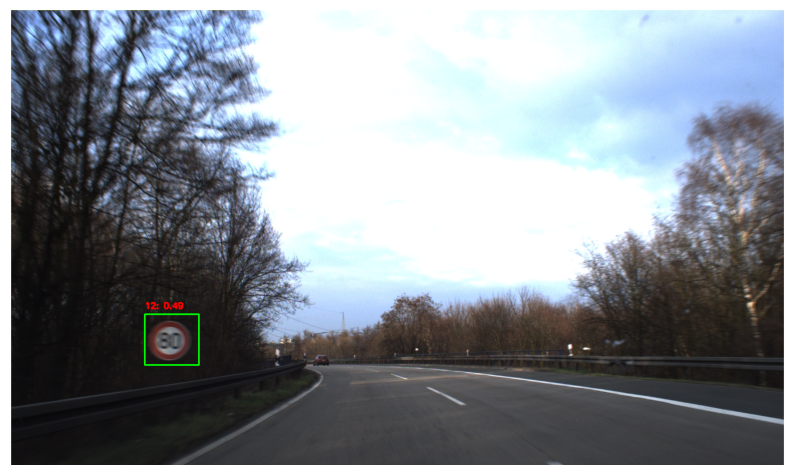

Visualizing predictions for: 00249.ppm


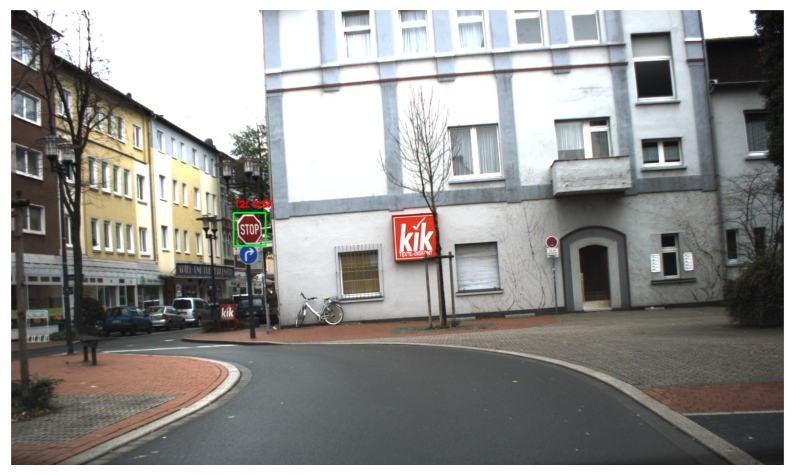

Visualizing predictions for: 00251.ppm


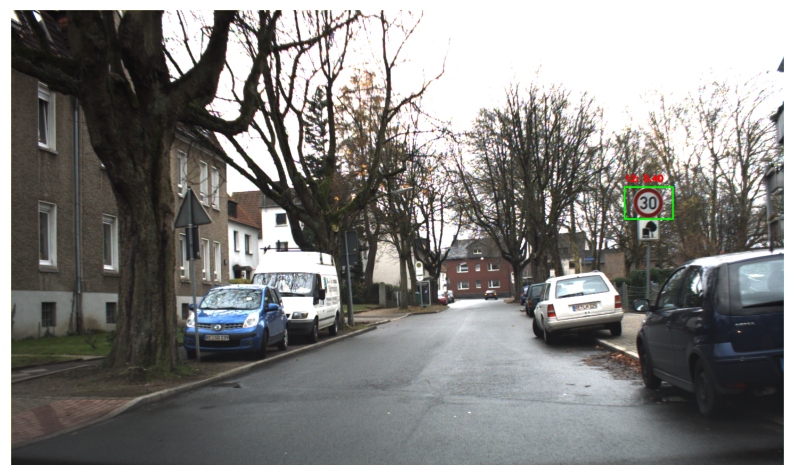

In [46]:
import os
import numpy as np
# Test images directory
test_images_dir = 'TestIJCNN2013Download'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

# Visualize predictions for a few images
for i in range(5):  # Visualize first 5 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    visualize_predictions(image_path, model, threshold=0.2)


In [ ]:
# ONLY FOR TRAINING CONTINUATION
from torchvision import transforms as T

# Define data augmentation transformations
transforms = T.Compose([
    T.RandomHorizontalFlip(),  # Flip image randomly horizontally
    T.RandomRotation(15),      # Rotate image randomly by up to 15 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
    T.RandomResizedCrop(416, scale=(0.8, 1.0)),  # Randomly crop and resize
    T.ToTensor(),              # Convert image to tensor
])

import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class GTSDBDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        with open(annotation_file, 'r') as f:
            self.annotations = f.readlines()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx].strip().split(';')
        img_path = os.path.join(self.root_dir, annotation[0])
        image = Image.open(img_path).convert("RGB")

        # Bounding box and label parsing
        bbox = list(map(float, annotation[1:5]))
        label = int(annotation[5])

        # Create a target dictionary
        target = {
            "boxes": torch.tensor([bbox], dtype=torch.float32),
            "labels": torch.tensor([label], dtype=torch.int64)
        }

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)

        return image, target

train_dataset = GTSDBDataset(train_dir, annotations_file, transforms=transforms)
test_loader = torch.utils.data.DataLoader(test_dir, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # increase learning rate later

# Use the transformations with augmentations for the dataset
train_dataset = GTSDBDataset(train_dir, annotations_file, transforms=transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# Load the model with the weights from epoch 21
model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoints/model_epoch_26_loss_9.1927.pth"))
model.to(device)# Training loop with saving model each epoch
# Training loop with saving model each epoch
def train_model(model, train_loader, test_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints'):
    model.train()
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        total_loss = 0

        for images, targets in train_loader:
            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

        # Save model checkpoint at the end of each epoch
        torch.save(model.state_dict(), f"{checkpoint_dir}/model_epoch_{epoch + 1}.pth")
        print(f"Model checkpoint saved after epoch {epoch + 1}")




train_model(model, train_loader, test_loader, device, optimizer, num_epochs=20, checkpoint_dir='/content/drive/MyDrive/checkpoints')

<ipython-input-18-009b41f2c88f>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoints/model_epoch_26_loss_9.


Epoch 1/20
Epoch 1, Loss: 10.6022
Model checkpoint saved after epoch 1

Epoch 2/20
Epoch 2, Loss: 11.0408
Model checkpoint saved after epoch 2

Epoch 3/20
Epoch 3, Loss: 10.4908
Model checkpoint saved after epoch 3

Epoch 4/20
Epoch 4, Loss: 10.1828
Model checkpoint saved after epoch 4

Epoch 5/20
Epoch 5, Loss: 10.3116
Model checkpoint saved after epoch 5

Epoch 6/20
Epoch 6, Loss: 11.2849
Model checkpoint saved after epoch 6

Epoch 7/20
Epoch 7, Loss: 10.8746
Model checkpoint saved after epoch 7

Epoch 8/20
Epoch 8, Loss: 10.7954
Model checkpoint saved after epoch 8

Epoch 9/20
Epoch 9, Loss: 10.4956
Model checkpoint saved after epoch 9

Epoch 10/20
Epoch 10, Loss: 10.1464
Model checkpoint saved after epoch 10

Epoch 11/20
Epoch 11, Loss: 10.3930
Model checkpoint saved after epoch 11

Epoch 12/20
Epoch 12, Loss: 10.0745
Model checkpoint saved after epoch 12

Epoch 13/20
Epoch 13, Loss: 10.2310
Model checkpoint saved after epoch 13

Epoch 14/20
Epoch 14, Loss: 10.1972
Model checkpoin

In [ ]:
# Validate annotations against actual files in the test directory
test_image_files = set(os.listdir(test_dir))  # List of all images in the test directory

# Filter the annotations
valid_annotations = []
with open(annotations_file, 'r') as f:
    for line in f.readlines():
        fields = line.strip().split(';')
        if len(fields) != 6:
            continue  # Skip malformed lines

        filename = fields[0]
        if filename in test_image_files:
            valid_annotations.append(line.strip())  # Only keep valid entries
        else:
            print(f"Skipping missing file: {filename}")

# Save filtered annotations back to a file (optional)
filtered_annotations_file = os.path.join(data_dir, 'filtered_gt.txt')
with open(filtered_annotations_file, 'w') as f:
    f.write('\n'.join(valid_annotations))

print(f"Filtered annotations saved to: {filtered_annotations_file}")


Filtered annotations saved to: /content/drive/MyDrive/ColabNotebooks/filtered_gt.txt


In [ ]:
def evaluate_map(model, dataloader, device, iou_threshold=0.3, confidence_threshold=0.1):
    """
    Evaluate mean Average Precision (mAP) on the test dataset with a lower confidence threshold.
    """
    model.eval()
    all_true_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                # Filter predictions by confidence threshold
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_scores = pred_scores[mask]
                pred_labels = pred_labels[mask]

                all_pred_boxes.append(pred_boxes)
                all_scores.append(pred_scores)
                all_labels.append(pred_labels)
                all_true_boxes.append(true_boxes)

    # Compute mAP as before
    aps = []
    for class_id in range(1, num_classes):  # Skip background class (class_id=0)
        precisions = []
        recalls = []
        scores = []

        for pred_boxes, pred_scores, pred_labels, true_boxes, true_labels in zip(
            all_pred_boxes, all_scores, all_labels, all_true_boxes, all_true_boxes
        ):
            # Filter predictions and ground truths for the current class
            pred_mask = pred_labels == class_id
            true_mask = true_labels == class_id

            class_pred_boxes = pred_boxes[pred_mask]
            class_pred_scores = pred_scores[pred_mask]
            class_true_boxes = true_boxes[true_mask]

            # Match predictions to ground truths using IoU
            matched_gt = set()
            for pred_box, score in zip(class_pred_boxes, class_pred_scores):
                best_iou = 0
                best_gt_idx = -1
                for gt_idx, true_box in enumerate(class_true_boxes):
                    if gt_idx in matched_gt:
                        continue
                    iou = box_iou(
                        torch.tensor(pred_box).unsqueeze(0),
                        torch.tensor(true_box).unsqueeze(0)
                    ).item()
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_gt_idx = gt_idx

                # Update matched ground truths
                if best_iou >= iou_threshold:
                    matched_gt.add(best_gt_idx)
                    precisions.append(1)
                    recalls.append(1)
                else:
                    precisions.append(0)
                    recalls.append(0)
                scores.append(score)

        # Compute AP for this class
        if scores:
            aps.append(average_precision_score(recalls, scores))

    # Calculate mean AP
    mAP = sum(aps) / len(aps) if aps else 0
    return mAP

# Evaluate mAP on the test dataset
mAP = evaluate_map(model, test_loader, device)
print(f"Test mAP: {mAP:.4f}")


Test mAP: 0.0000
